# Extract GPS data from dashcam footage
gps_bend_finding_with_gaussian_smoothing_and_DBSCAN_clustering_and_circle_fitting

In [130]:
ids = [42]
min_string_length = 9
DATASET_PATH = "/home/aap9002/Stereo-Road-Curvature-Dashcam"
min_speed_filter = 5

### Pipeline support with passing forced parameters

In [131]:
import argparse

parser = argparse.ArgumentParser(
    description="Process input and output paths for video processing."
)

parser.add_argument(
    "-i", "--input", 
    help="Path to the input video file.", 
    required=False
)

parser.add_argument(
    "-o", "--output", 
    help="Path to the output folder.", 
    required=False
)

parser.add_argument(
    "--f", "--kernel_launcher", 
    help="Path to the kernel launcher file.",
    required=False
)

_StoreAction(option_strings=['--f', '--kernel_launcher'], dest='f', nargs=None, const=None, default=None, type=None, choices=None, required=False, help='Path to the kernel launcher file.', metavar=None)

In [132]:
args = parser.parse_args()

if args.input and args.output:
    args = parser.parse_args()
    
    FORCE_INPUT_AND_OUTPUT_PATHS = True
    FORCED_video_file_path = args.input
    FORCED_output_folder = args.output
    print("System arguments detected:", args)
else:
    FORCE_INPUT_AND_OUTPUT_PATHS = False


### Helper

In [133]:
import re
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.cluster import DBSCAN
from pyproj import Transformer

In [134]:
def count_frames(video_path:str):
    """Count the number of frames in the video

    Args:
        video_path (str): The path to the video

    Returns:
        int: The number of frames in the video
    """
    
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return length

def get_file_and_output_folder(id:int):
    """Get the file path and output folder for the given id

    Args:
        id (int): The id of the video

    Returns:
        tuple[str, str]: The file path and the output_folder
    """
    
    file_path = f"{DATASET_PATH}/day/{id:03d}/R.MP4"
    output_folder = f"{DATASET_PATH}/day/{id:03d}/bends"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f'File {file_path} not found')
    
    print(f'Processing video {id:03d} with {count_frames(file_path)} frames')
    os.makedirs(output_folder, exist_ok=True)
    print(f'Results will be saved in {output_folder}')
    return file_path, output_folder

def time_stamp_to_seconds(time_stamp:str):
    """Convert a time stamp to seconds

    Args:
        time_stamp (str): The time stamp in the format HHMMSS:sss

    Returns:
        int: The seconds since midnight
    """
    
    hours = int(time_stamp[:2])
    minutes = int(time_stamp[2:4])
    seconds = int(time_stamp[4:6])
    milliseconds = int(time_stamp[7:])

    return (hours*60*60 + minutes*60 + seconds)*1000 + milliseconds

# Lat and Long to X and Y

In [135]:
# https://link-springer-com.manchester.idm.oclc.org/article/10.1007/s00190-023-01815-0
def lat_lon_to_x_y(lat:float, lon:float, height:float = 0):
    """Convert latitude, longitude and height to x, y and z

    Args:
        lat (float): latitude
        lon (float): longitude
        height (float): height above sea level
    """
    lat = np.radians(lat)
    lon = np.radians(lon)

    a = 6378137.0 # equatorial radius
    f = 0.003352810681183637418 # flattening

    e2 = f*(2-f) # first eccentricity squared

    Rn = a / np.sqrt(1 - e2*np.sin(lat)**2) # radius of curvature in the prime vertical

    lat = np.radians(lat)
    lon = np.radians(lon)

    # calculate x, y, z
    x = (Rn + height) * np.cos(lat) * np.cos(lon)
    y = (Rn + height) * np.cos(lat) * np.sin(lon)
    z = (Rn*(1-e2) + height) * np.sin(lat)

    return x, y, z

def lat_lon_to_BGS_X_Y(lat:float, lon:float):
    """Convert latitude and longitude to BGS X and Y

    Args:
        lat (float): latitude
        lon (float): longitude

    Returns:
        tuple: The BGS X and Y coordinates
    """
    # GPS - EPSG:4326  https://epsg.io/4326
    # BGS - EPSG:27700 https://epsg.io/27700
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700")
    bgs_format =  transformer.transform(lat, lon)

    northing = bgs_format[0]
    easting = bgs_format[1]

    return easting, northing

test_lat_kilburn = 53.4675254
test_lon_kilburn = -2.234003
test_lat_crewe = 53.09863295
test_lon_crewe = -2.45823645
test_conversion_kilburn = lat_lon_to_x_y(test_lat_kilburn, test_lon_kilburn)
test_conversion_crewe = lat_lon_to_x_y(test_lat_crewe, test_lon_crewe)
test_bsg_kilburn = lat_lon_to_BGS_X_Y(test_lat_kilburn, test_lon_kilburn)
test_bsg_crewe = lat_lon_to_BGS_X_Y(test_lat_crewe, test_lon_crewe)

print (f'Kilburn: X: {test_conversion_kilburn[0]}, Y: {test_conversion_kilburn[1]}')
print (f'Crewe: X: {test_conversion_crewe[0]}, Y: {test_conversion_crewe[1]}')
print (f'Kilburn BGS: X: {test_bsg_kilburn[0]}, Y: {test_bsg_kilburn[1]}')
print (f'Crewe BGS: X: {test_bsg_crewe[0]}, Y: {test_bsg_crewe[1]}')

conversion_distance_to_crewe = np.sqrt((test_conversion_kilburn[0] - test_conversion_crewe[0])**2 + (test_conversion_kilburn[1] - test_conversion_crewe[1])**2)
conversion_distance_to_crewe_bgs = np.sqrt((test_bsg_kilburn[0] - test_bsg_crewe[0])**2 + (test_bsg_kilburn[1] - test_bsg_crewe[1])**2)

print (f"According to google earth the distance between Kilburn and Crewe is 43,188.27 meters")
print(f'Distance between Kilburn and Crewe in meters: {conversion_distance_to_crewe}')
print(f'Distance between Kilburn and Crewe in meters (BGS): {conversion_distance_to_crewe_bgs}')

Kilburn: X: 6391116.323565937, Y: -4349.259055188549
Crewe: X: 6390995.086329557, Y: -4785.716345837706
Kilburn BGS: X: 396779.55851404776, Y: 384563.1150520657
Crewe BGS: X: 355812.82182048995, Y: 369414.1694847972
According to google earth the distance between Kilburn and Crewe is 43,188.27 meters
Distance between Kilburn and Crewe in meters: 452.98281870925007
Distance between Kilburn and Crewe in meters (BGS): 43677.958596062614


In [136]:
if FORCE_INPUT_AND_OUTPUT_PATHS:
    file_path = FORCED_video_file_path
    output_folder = FORCED_output_folder
else:
    file_path, output_folder = get_file_and_output_folder(ids[0])

Processing video 042 with 5400 frames
Results will be saved in /home/aap9002/Stereo-Road-Curvature-Dashcam/day/042/bends


In [137]:
# !firefox {file_path} # display the video

# Read file contents

### NMEA string extraction

In [138]:
def getNMEAStringsFromFile(file_path:str):
    """Get the NMEA strings from the file

    Args:
        file_path (str): The path to the file

    Returns:
        List[str]: The GPRMC|GPGGA strings from the file
    """
    strings = ""
    with open(file_path, "rb") as f:
        strings = f.read()

    pattern =  rb'\$(?:GPRMC|GPGGA)[ -~]{' + str(min_string_length).encode() + rb',}'
    strings = re.findall(pattern, strings)    
    return [s.decode('utf-8', errors='ignore') for s in strings]

Get the NMEA strings from the video file.

In [139]:
data = getNMEAStringsFromFile(file_path)
frame_count = count_frames(file_path)
print(f'Found {len(data)} GPS records, of which {frame_count} frames are available')
data[:10]

Found 3998 GPS records, of which 5400 frames are available


['$GPRMC,093819.100,A,5309.11529,N,00223.63308,W,25.677,320.28,241124,,,A*6F',
 '$GPGGA,093819.100,5309.11529,N,00223.63308,W,1,12,0.78,53.4,M,49.7,M,,*53',
 '$GPRMC,093819.200,A,5309.11584,N,00223.63383,W,26.010,320.77,241124,,,A*66',
 '$GPGGA,093819.200,5309.11584,N,00223.63383,W,1,12,0.78,53.4,M,49.7,M,,*54',
 '$GPRMC,093819.300,A,5309.11640,N,00223.63460,W,26.048,320.63,241124,,,A*6E',
 '$GPGGA,093819.300,5309.11640,N,00223.63460,W,1,11,0.91,53.4,M,49.7,M,,*50',
 '$GPRMC,093819.400,A,5309.11695,N,00223.63540,W,26.450,319.97,241124,,,A*6E',
 '$GPGGA,093819.400,5309.11695,N,00223.63540,W,1,11,0.91,53.4,M,49.7,M,,*5C',
 '$GPRMC,093819.500,A,5309.11751,N,00223.63621,W,26.805,318.89,241124,,,A*60',
 '$GPGGA,093819.500,5309.11751,N,00223.63621,W,1,11,0.91,53.3,M,49.7,M,,*57']

NMEA string parsing and data extraction

In [140]:
def knots_to_mph(knots:float):
    """Convert knots to miles per hour

    Args:
        knots (float): The speed in knots

    Returns:
        float: The speed in miles per hour
    """
    return knots * 1.15078

def DMS_to_decimal(lon:str, lon_heading:str, lat:str, lat_heading:str):
    """Convert Degrees Minutes Seconds to decimal
    lon: dddmm.mmmm
    lat: ddmm.mmmm

    Args:
        lon (str): The longitude in DMS format
        lon_heading (str): The heading for the longitude
        lat (str): The latitude in DMS format
        lat_heading (str): The heading for the latitude

    Returns:
        float, float: The latitude and longitude in decimal format
    """
    
    lon_degrees = int(lon[:3])
    lon_minutes = float(lon[3:])
    lon_decimal = lon_degrees + lon_minutes/60
    if lon_heading == 'W':
        lon_decimal = -lon_decimal

    lat_degrees = int(lat[:2])
    lat_minutes = float(lat[2:])
    lat_decimal = lat_degrees + lat_minutes/60
    if lat_heading == 'S':
        lat_decimal = -lat_decimal

    return lat_decimal, lon_decimal

def parse_gprmc(input_sequence:str):
    """Parse the GPRMC and GPGGA string and extract the latitude, longitude, height and speed

    Args:
        input_sequence (str[]): [GPRMC string, GPGGA string]

    Returns:
        dict: The extracted values as a dictionary
    """
    # $GPRMC,<time>,<status>,<latitude>,<N/S>,<longitude>,<E/W>,<speed>,<course>,<date>,<magnetic variation>,<E/W>,<checksum>
    parts_GPRMC = input_sequence[0].split(',')
    if len(parts_GPRMC) < 10 or parts_GPRMC[0] != '$GPRMC':
        # print(f'Invalid GPRMC string: {input_sequence}')
        return None
    
    # $GPGGA,<time>,<latitude>,<N/S>,<longitude>,<E/W>,<quality>,<satellites>,<HDOP>,<height>,<height unit>,<geoid separation>,<geoid separation unit>,<age of differential data>,<station ID>,<checksum>
    parts_GPGGA = input_sequence[1].split(',')
    if len(parts_GPGGA) < 10 or parts_GPGGA[0] != '$GPGGA':
        # print(f'Invalid GPGGA string: {input_sequence}')
        return None

    
    # Extract latitude and longitude with direction
    time = parts_GPRMC[1]
    valid = parts_GPRMC[2]  # A - data valid, V - data invalid
    latitude = parts_GPRMC[3]
    lat_direction = parts_GPRMC[4]
    longitude = parts_GPRMC[5]
    lon_direction = parts_GPRMC[6]
    height = parts_GPGGA[9]  # Height above sea level
    speed = parts_GPRMC[7]  # Speed in knots

    # Convert latitude and longitude to decimal
    numeric_lat, numeric_lon = DMS_to_decimal(longitude, lon_direction, latitude, lat_direction)

    if valid == 'A': # check if the data record is valid
        speed = knots_to_mph(float(speed))  # Convert speed to mph
        
    # Return the extracted values as a dictionary
    return {
        "time": time,
        "valid": True if valid == 'A' else False,
        "latitude": numeric_lat,
        "longitude": numeric_lon,
        "height": height,
        "speed": speed
    }

In [141]:
# parse gps records at a step of two to capture both GPRMC and GPGGA records
positions = []
for i in range(0, len(data), 2):
    lat_lon = parse_gprmc(data[i:i+2])
    if lat_lon:
        positions.append(lat_lon)

# status of the records
print(f"Found {len(positions)} positions")
print("valid positions:", len([p for p in positions if p['valid']]))
print("invalid positions:", len([p for p in positions if not p['valid']]))

# remove records with the same values
positions = [dict(t) for t in {tuple(d.items()) for d in positions}]
print(f"Unique positions: {len(positions)}")

Found 1999 positions
valid positions: 1999
invalid positions: 0
Unique positions: 1819


### Video Metadata extraction

In [142]:
cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = cap.get(cv2.CAP_PROP_FPS)

print(f"Total frames: {total_frames}")

print(f"Frame rate: {frame_rate}")

Total frames: 5400
Frame rate: 29.97002997002997


In [173]:
# filter out invalid GPS records
print(f"Total positions: {len(positions)}")
positions = [p for p in positions if p['valid']]
print(f"Valid positions: {len(positions)}")

positions[:2]

Total positions: 1698
Valid positions: 1698


[{'time': '093819.100',
  'valid': True,
  'latitude': 53.1519215,
  'longitude': -2.3938846666666667,
  'height': '53.4',
  'speed': 29.548578059999997,
  'x': 361715.35644632427,
  'y': 373755.7105353316},
 {'time': '093819.200',
  'valid': True,
  'latitude': 53.151930666666665,
  'longitude': -2.3938971666666666,
  'height': '53.4',
  'speed': 29.9317878,
  'x': 361716.3808139971,
  'y': 373754.88019801734}]

### Convert Lat Lon to X, Y
Convert to a 2D plane to convert out gps points to a meter based X, Y coordinate system
- improves relative distance calculation accuracy
- creates a relative scale between lon and lat
- improves clustering accuracy
- improves circle fitting accuracy

In [145]:
# process the positions to get x, y, z
# for position in positions:
#     lat, lon = position['latitude'], position['longitude']
#     lat = float(lat.split()[0])
#     lon = float(lon.split()[0])
#     h = float(position['height'])
#     position['x'], position['y'], position['z'] = lat_lon_to_x_y(lat, lon, h)

for position in positions:
    lat, lon = position['latitude'], position['longitude']
    position['x'], position['y'] = lat_lon_to_BGS_X_Y(lat, lon)


Original_Positions = positions.copy()
positions[:2]

[{'time': '093819.100',
  'valid': True,
  'latitude': 53.1519215,
  'longitude': -2.3938846666666667,
  'height': '53.4',
  'speed': 29.548578059999997,
  'x': 361715.35644632427,
  'y': 373755.7105353316},
 {'time': '093819.200',
  'valid': True,
  'latitude': 53.151930666666665,
  'longitude': -2.3938971666666666,
  'height': '53.4',
  'speed': 29.9317878,
  'x': 361716.3808139971,
  'y': 373754.88019801734}]

# Plot GPS positions on graph

Text(0.5, 1.0, 'Valid GPS positions > 5 MPH - Including GPS Outliers')

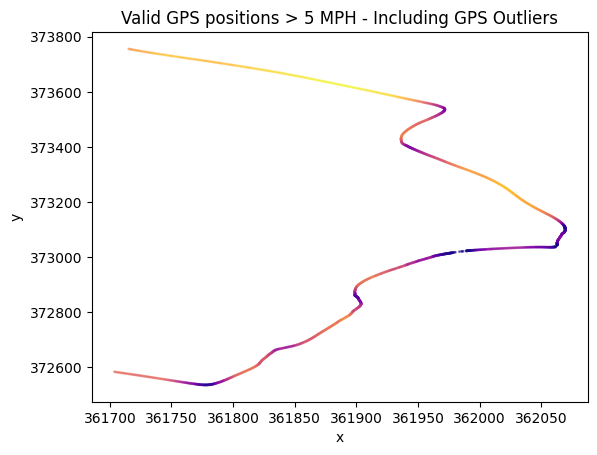

In [172]:
plt.close('all')
x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

speeds = [pos['speed'] for pos in positions]

norm = plt.Normalize(min(speeds), max(speeds))
cmap = plt.cm.plasma

plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Valid GPS positions > {min_speed_filter} MPH - Including GPS Outliers')

Text(0.5, 1.0, 'Valid GPS positions > 5 MPH - Including GPS Outliers')

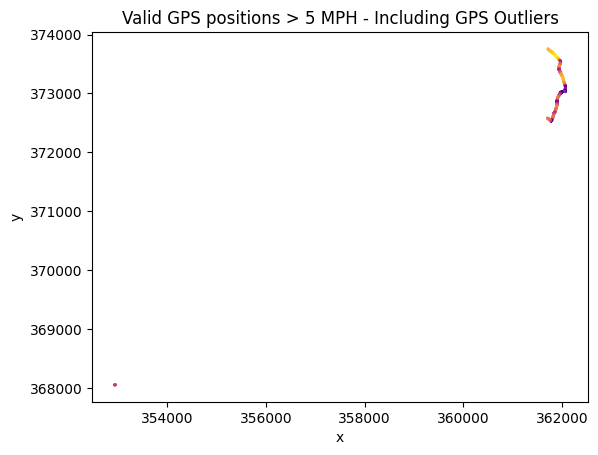

In [147]:
plt.close('all')

x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

speeds = [pos['speed'] for pos in positions]

norm = plt.Normalize(min(speeds), max(speeds))
cmap = plt.cm.plasma

plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Valid GPS positions > {min_speed_filter} MPH - Including GPS Outliers')

### Remove outliers from our data

Median x: 361945.1341838429
Median y: 373035.8433123795


Text(0.5, 1.0, 'Valid GPS positions > 5 MPH')

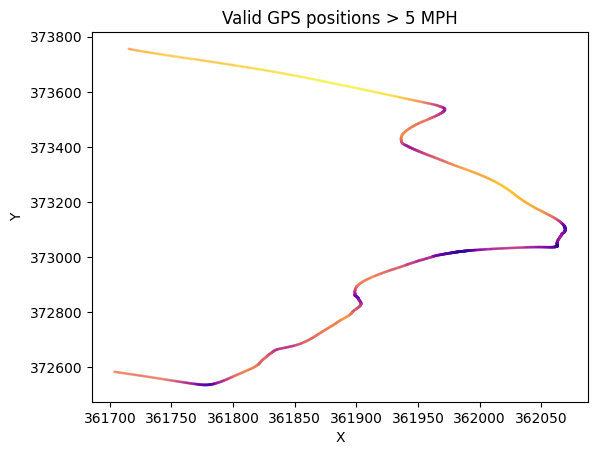

In [148]:
plt.close('all')

MIN_DISTANCE_OUTLIER_FILTER = 1000 # 1KM distance from the median

x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

# calculate the median x and y
median_x = np.median(x)
median_y = np.median(y)
print(f'Median x: {median_x}')
print(f'Median y: {median_y}')

# filter out the points that are not within the MIN_DISTANCE_OUTLIER_FILTER
positions = [
    pos for pos in positions
        if abs(pos['x'] - median_x) < MIN_DISTANCE_OUTLIER_FILTER and 
            abs(pos['y'] - median_y) < MIN_DISTANCE_OUTLIER_FILTER
        ]

# plot the filtered points
x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]
speeds = [pos['speed'] for pos in positions]

plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Valid GPS positions > {min_speed_filter} MPH')

In [149]:
# Get start and end time for frame estimation
positions = sorted(positions, key=lambda x: x['time'])
STARTING_TIME = time_stamp_to_seconds(positions[0]['time'])
print(f"Starting time: {STARTING_TIME}")

END_TIME = time_stamp_to_seconds(positions[-1]['time'])
print(f"Ending time: {END_TIME}")

Starting time: 34699100
Ending time: 34879300


### Remove invalid records and records under min_speed_filter mph

In [150]:
def filter_invalid_and_low_mph_records(positions):
    """Filter the data points to remove
        - invalid points
        - points less than min_speed_filter mph
        - points with the same latitude and longitude
    
    Args:
        positions (List[dict]): The list of positions
    
    Returns:
        List[dict]: The filtered list of positions
    """
    
    filtered_positions = []
    for i in range(len(positions)):
        if not positions[i]['valid']:
            continue

        if positions[i]['speed'] < min_speed_filter:
            continue

        filtered_positions.append(positions[i])
    return filtered_positions

In [151]:
positions = filter_invalid_and_low_mph_records(positions)
positions = sorted(positions, key=lambda x: x['time']) # sort by time

print(f"{len(positions)} positions after filtering")
positions[:2]

1698 positions after filtering


[{'time': '093819.100',
  'valid': True,
  'latitude': 53.1519215,
  'longitude': -2.3938846666666667,
  'height': '53.4',
  'speed': 29.548578059999997,
  'x': 361715.35644632427,
  'y': 373755.7105353316},
 {'time': '093819.200',
  'valid': True,
  'latitude': 53.151930666666665,
  'longitude': -2.3938971666666666,
  'height': '53.4',
  'speed': 29.9317878,
  'x': 361716.3808139971,
  'y': 373754.88019801734}]

# Find closest position entry to point of interest

In [152]:
def get_points_near_a_cluster_estimated_center(
        cluster_center:list[float],
        positions:list[dict],
        distance_threshold:float = 100):
    """Get the points near a cluster estimated center

    Args:
        cluster_center (list[float]): list of estimated centers
        positions (list[dict]): list of gps positions
        distance_threshold (float, optional): The distance threshold. Defaults to 100.

    Returns:
        list[dict]: The positions within the distance threshold
    """
    points = []
    for position in positions:
        x = float(position['x'])
        y = float(position['y'])
        distance = np.sqrt((x - cluster_center[0])**2 + (y - cluster_center[1])**2)
        if distance < distance_threshold:
            points.append(position)
    return points

# Find bends

In [153]:
def apply_median_filter(records:list[float], size:int = 5):
    """Apply a median filter to a list

    Args:
        records (list[float]): The list of points
        size (int, optional): Kernel size. Defaults to 5.

    Returns:
        list[float]: The filtered points
    """

    temp = records.copy() # create a copy to avoid modifying the original list
    # slide a window of size 2*size+1 over the records
    for i in range(size, len(records)-size):
        temp[i] = np.median(records[i-size:i+size])
    return temp

In [154]:
def get_accumulated_distance(x_pos: list[float], y_pos: list[float]) -> list[float]:
    """Get the accumulated distance from x and y positions

    Args:
        x_pos (list[float]): x values
        y_pos (list[float]): y values

    Returns:
        list[float]: list of accumulated distances
    """

    distance = 0.0
    distances = [0.0]
    for i in range(1, len(x_pos)):
        dx = x_pos[i] - x_pos[i-1]
        dy = y_pos[i] - y_pos[i-1]
        distance += np.hypot(dx, dy)
        distances.append(distance)
    return distances

def get_smoothed_sequence_angles(x_pos:list[float], y_pos:list[float], meters:int = 5) -> list[float]:
    """Get the smoothed sequence angles from x and y positions sequence

    Args:
        x_pos (list[float]): x positions
        y_pos (list[float]): y positions

    Returns:
        list[float]: The smoothed sequence angles
    """

    x_pos = apply_median_filter(x_pos, 3)
    y_pos = apply_median_filter(y_pos, 3)

    diff_x = np.diff(x_pos)
    diff_y = np.diff(y_pos)

    accumulated_distance = get_accumulated_distance(x_pos, y_pos)

    angles = []

    for i in range(1, len(accumulated_distance)):
        # find all positions within 5 meters before and after the current position
        current_distance = accumulated_distance[i]
        low_distance = max(0, current_distance - meters)
        high_distance = min(accumulated_distance[-1], current_distance + meters)

        low_index = np.searchsorted(accumulated_distance, low_distance, side='left')
        high_index = np.searchsorted(accumulated_distance, high_distance, side='right')
        high_index = min(high_index, len(accumulated_distance))

        # print(low_index, i, high_index)

        # calculate the angle
        before_dx = np.sum(diff_x[low_index:i])
        before_dy = np.sum(diff_y[low_index:i])
        after_dx = np.sum(diff_x[i:high_index])
        after_dy = np.sum(diff_y[i:high_index])
        
        # Skip zero vectors to avoid NaN
        if (before_dx == 0 and before_dy == 0) or (after_dx == 0 and after_dy == 0):
            angles.append(0.0)
            continue
        
        # Compute angle
        dot = before_dx * after_dx + before_dy * after_dy
        cross = before_dx * after_dy - before_dy * after_dx
        angle = np.arctan2(cross, dot)
        angles.append(angle)

    angles_rad = np.array(angles)
    complex_angles = np.exp(1j * angles_rad)

    # smooth angles with gaussian filter
    gaussian = np.exp(-np.linspace(-2, 2, 5)**2)
    gaussian /= gaussian.sum()
    smoothed_complex = np.convolve(complex_angles, gaussian, mode='same')

    # Convert back to angles
    smoothed_angles = np.angle(smoothed_complex)
    smoothed_degrees = np.degrees(smoothed_angles)

    return smoothed_degrees

### Config parameters for bend ROI findings

In [155]:
lower_threshold = 10  # degrees
DB_SCAN_EPS = 10
DB_SCAN_MIN_SAMPLES = 3

Found 1697 angles
[-0.36546766 -0.09686054  0.49492317  1.2770411   1.99703894]


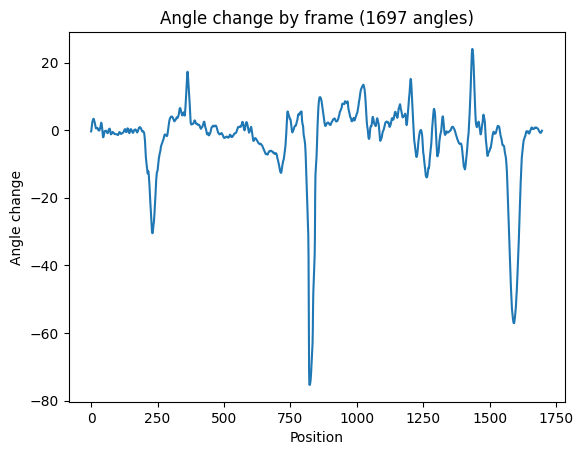

In [156]:
plt.close('all')

positions_ordered_by_time = sorted(positions, key=lambda x: time_stamp_to_seconds(x['time']))

x_pos = [pos['x'] for pos in positions_ordered_by_time]
y_pos = [pos['y'] for pos in positions_ordered_by_time]
speeds = [pos['speed'] for pos in positions_ordered_by_time]

angles = get_smoothed_sequence_angles(x_pos, y_pos, meters=10)

print(f"Found {len(angles)} angles")
print(angles[:5])

# angles_derivative = np.gradient(angles) # get the first derivative of the angles

angles_derivative = angles # get the first derivative of the angles

plot_angles = angles_derivative
plt.title(f"Angle change by frame ({len(angles)} angles)")
plt.xlabel("Position")
plt.ylabel("Angle change")
plt.plot(plot_angles)
plt.savefig(os.path.join(output_folder, "angle_graph.png"))

Found 1 bends
[-10.28543388 -10.91285231 -11.60071692 -12.32161494 -12.83092931]
Found 10 bends after clustering


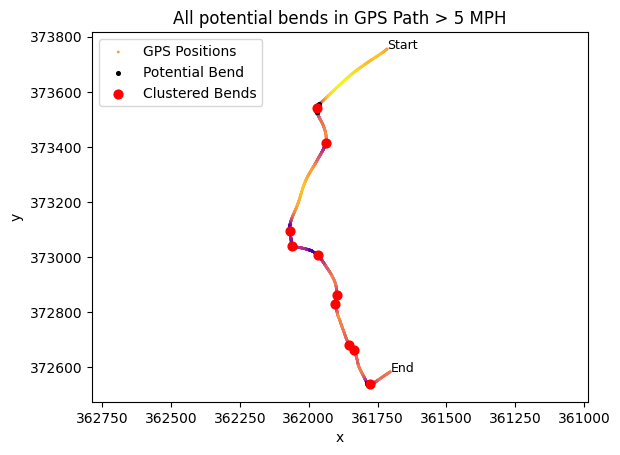

In [157]:
plt.close('all')

# bends above the threshold
bends = np.where(np.abs(angles_derivative) > lower_threshold)

print(f"Found {len(bends)} bends")
print(angles_derivative[bends][:5])

# cluster bends
bends_positions = np.array(list(zip(x_pos, y_pos)))[bends]

temp_store_bends = bends_positions.copy() # Store the potential bends for plotting later

# bends = cluster.vq.kmeans(bends_positions, )[0] # not applicable since we need to know K
# Apply DBSCAN clustering (automatic K)
if len(bends_positions) > 1:
    dbscan = DBSCAN(eps=DB_SCAN_EPS, min_samples=DB_SCAN_MIN_SAMPLES, metric="euclidean")  # Adjust eps based on your GPS resolution
    labels = dbscan.fit_predict(bends_positions)
    
    # Get unique cluster centers
    unique_labels = set(labels)
    cluster_centers = np.array([bends_positions[labels == i].mean(axis=0) for i in unique_labels if i != -1])  # Ignore noise
else:
    cluster_centers = bends_positions  # If no clustering is needed, keep original bends

print(f"Found {len(cluster_centers)} bends after clustering")

plt.scatter(
    x_pos,
    y_pos,
    c=[cmap(norm(float(s))) for s in speeds],
    s=1,
    label='GPS Positions'
)

# add start and end points TEXT LABEL
plt.text(
    x_pos[0],
    y_pos[0],
    'Start',
    fontsize=9,
    color='black'
)

plt.text(
    x_pos[-1],
    y_pos[-1],
    'End',
    fontsize=9,
    color='black'
)

plt.scatter(
    temp_store_bends[:, 0],
    temp_store_bends[:, 1],
    color='black',
    label='Potential Bend',
    s=7
)

if len(cluster_centers) > 0:
    plt.scatter(
        cluster_centers[:,0],
        cluster_centers[:,1],
        color='red',
        label='Clustered Bends',
        s=40
    )
else:
    plt.legend(["GPS Positions", "Potential Bend"])
    
plt.title(f"All potential bends in GPS Path > {min_speed_filter} MPH")
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.axis('equal')
plt.gca().invert_xaxis()


plt.savefig(os.path.join(output_folder, "bends.png"))

In [158]:
print(f"total of {len(cluster_centers)} potential bend clusters found")
cluster_centers

total of 10 potential bend clusters found


array([[361969.37018058, 373539.89259084],
       [361937.46640453, 373413.04776702],
       [362069.22212149, 373095.91831145],
       [362059.56972576, 373038.79039861],
       [361965.83758217, 373006.56153192],
       [361898.81451213, 372861.78822375],
       [361903.55644694, 372828.94804563],
       [361851.94124336, 372681.84652759],
       [361835.60675138, 372664.11042483],
       [361778.85149023, 372538.32000921]])

### Estimate relevant frames

In [159]:
def time_stamp_to_frame_number(time_stamp:str, STARTING_TIME:int = STARTING_TIME, END_TIME:int = END_TIME, total_frames:int = total_frames):
    """Estimate frame number using the timestamp

    Args:
        time_stamp (str): The time stamp to convert
        STARTING_TIME (int, optional): video starting time stamp. Defaults to STARTING_TIME.
        END_TIME (int, optional): video ending timestamp. Defaults to END_TIME.
        total_frames (int, optional): total number of frames. Defaults to total_frames.

    Returns:
        int: frame number
    """
    # calculate the difference between the time stamp and the starting time
    diff = time_stamp_to_seconds(time_stamp) - STARTING_TIME

    total_time = END_TIME - STARTING_TIME

    # print(f"diff: {diff}, toal_time: {total_time}")

    if total_time <= 0:
        return 0
    
    # estimate the frame number
    predict_frame_number = int((diff / total_time) * total_frames)
    
    return predict_frame_number

def get_closest_position_based_on_lat_lon(x:float, y:float, positions:list[dict]):
    """Get the closest position based on x and y

    Args:
        lat (float): x
        lon (float): y
        positions (list[dict], optional): list of all positions. Defaults to positions.

    Returns:
        dict: The closest position
    """
    min_distance = float('inf')
    closest_position = None

    # print(positions[:5])

    for position in positions:
        p_x = position['x']
        p_y = position['y']
        distance = np.sqrt((p_x - x)**2 + (p_y - y)**2)

        if distance < min_distance:
            min_distance = distance
            closest_position = position

    return closest_position


def get_frame_number_based_on_bend_x_y(cluster_centers:list[list[float]], positions:list[dict] = positions):
    """Get the frame number based on the bend x and y for each cluster center

    Args:
        cluster_centers (list[list[float]]): list of cluster centers
        positions (list[dict], optional): list of considered positions. Defaults to positions.

    Returns:
        list[int]: list of frame numbers
    """
    frame_numbers = []
    for bend in cluster_centers:
        closest_position = get_closest_position_based_on_lat_lon(bend[0], bend[1], positions)
        frame_number = time_stamp_to_frame_number(closest_position['time'])
        # print(f"frame_number: {frame_number}")
        frame_numbers.append(frame_number)

    return frame_numbers

In [160]:
frame_numbers = get_frame_number_based_on_bend_x_y(cluster_centers)

print(f"Estimated frame numbers: {frame_numbers}")

Estimated frame numbers: [686, 1087, 2139, 2604, 3374, 3913, 4102, 4524, 4614, 5076]


### Output images of estimated frames

Total frames: 5400


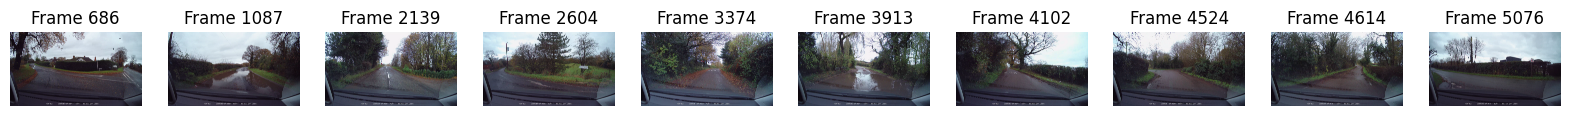

In [161]:

frame_numbers = sorted(frame_numbers)

def print_frames(frame_numbers:list[int], file_path:str = file_path):
    plt.close('all')
    
    frames = []

    cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)

    for frame_number in frame_numbers:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
        else:
            print(f"Warning: Could not read frame {frame_number}")
    
    cap.release()
    
    if frames:
        fig, axes = plt.subplots(1, len(frames), figsize=(20, 10))
        if len(frames) == 1:
            axes.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
            axes.axis('off')
            axes.set_title(f"Frame {frame_numbers[0]}")
        else:
            for i, frame in enumerate(frames):
                axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                axes[i].axis('off')
                axes[i].set_title(f"Frame {frame_numbers[i]}")
    else:
        print("No frames to display")

    return frames

frames = print_frames(frame_numbers)

print(f"Total frames: {total_frames}")

In [162]:
for i, frame in enumerate(frames):
    output_file = os.path.join(output_folder, f"bend_{i}.jpg")
    cv2.imwrite(output_file, frame)


# Calculate Bends in ROI

In [ ]:
def plot_bend(bend_name:str, cluster_center:list[float], points:list[dict], focused_positions:list[dict]=None):
    """Plot the bend with the given name and points

    Args:
        bend_name (str): plot title
        points (list[dict]): list of points
    """
    plt.close('all')
    points = sorted(points, key=lambda x: time_stamp_to_seconds(x['time']))

    x = [float(pos['x']) for pos in points]
    y = [float(pos['y']) for pos in points]
    
    plt.scatter(x, y, s=1)
    plt.scatter(cluster_center[0], cluster_center[1], color='red', s=40)
    if not focused_positions is None:
        focused_x = [float(pos['x']) for pos in focused_positions]
        focused_y = [float(pos['y']) for pos in focused_positions]
        plt.scatter(focused_x, focused_y, color='green', s=40)

    plt.text(
        x[0],
        y[0],
        'Segment Start',
        fontsize=9,
        color='black'
    )

    plt.text(
        x[-1],
        y[-1],
        'Segment End',
        fontsize=9,
        color='black'
    )

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'GPS positions near {bend_name}')
    # flip x axis
    plt.gca().invert_xaxis()
    plt.axis('equal')

    plt.savefig(os.path.join(output_folder, f"{bend_name}.png"))

    if args.f:
        plt.show()
    else:
        plt.close('all')

find first curve of a series of points

In [175]:
def find_first_bend_from_series(points:list[dict], min_degree_threshold:float = 6):
    """Find the initial bend from the series of points

    Args:
        points (list[dict]): list of points

    Returns:
        list[float]: The initial bend
    """
    points = sorted(points, key=lambda x: time_stamp_to_seconds(x['time']))

    x = [pos['x'] for pos in points]
    y = [pos['y'] for pos in points]

    # x = np.convolve(x, np.ones(3) /3, mode='valid')
    # y = np.convolve(y, np.ones(3) / 3, mode='valid')

    angles = get_smoothed_sequence_angles(x, y, meters=10)

    print(angles[:5])

    first_bend_found = False
    first_bend_sign = None

    tolerance = 3

    first_bend_positions = []
    for i in range(5, len(angles)):
        sign = np.sign(angles[i])
        if abs(angles[i]) > min_degree_threshold:
            if not first_bend_found:
                first_bend_positions.append(points[i])
                first_bend_found = True
                first_bend_sign = sign
            elif first_bend_sign == sign:
                first_bend_positions.append(points[i])
            
            continue

        if first_bend_found and first_bend_sign != sign:
            if tolerance <= 0:
                break
            tolerance -= 1  

    if not first_bend_found:
        print("No first bend found")
        return None, None

    # determine if the first bend is a left or right bend
    if first_bend_sign < 0:
        print("First bend is a left bend")
    else:
        print("First bend is a right bend")

    return first_bend_positions, first_bend_sign

Bend 0: 113 points near the center - Avg Speed: 20.48661328353982
[0.07240711 0.43786339 0.62427265 0.70781166 0.74295352]
First bend is a left bend
Start of focused points: 617


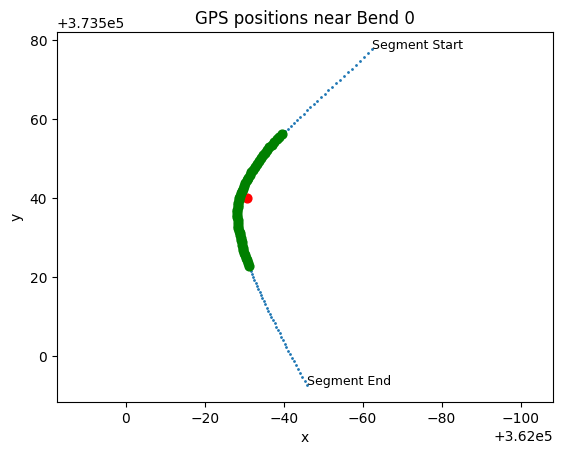

Bend 1: 110 points near the center - Avg Speed: 20.42402251672727
[2.361681   2.58254815 2.57607518 2.40992843 2.47329026]
First bend is a right bend
Start of focused points: 1066


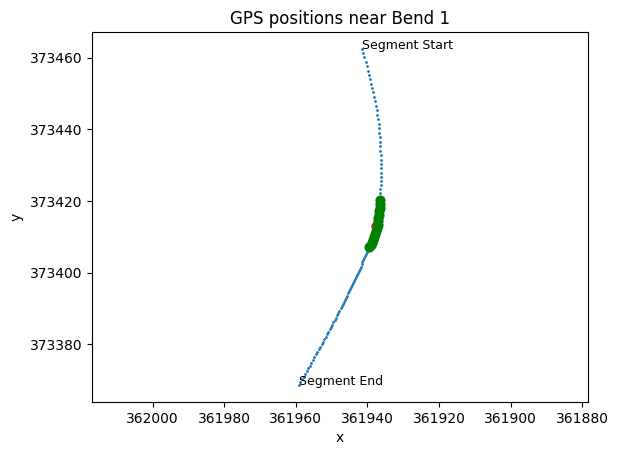

Bend 2: 195 points near the center - Avg Speed: 11.488779672102563
[-0.58584203 -0.79298253 -1.17239679 -1.5494901  -1.75524683]
First bend is a left bend
Start of focused points: 1968


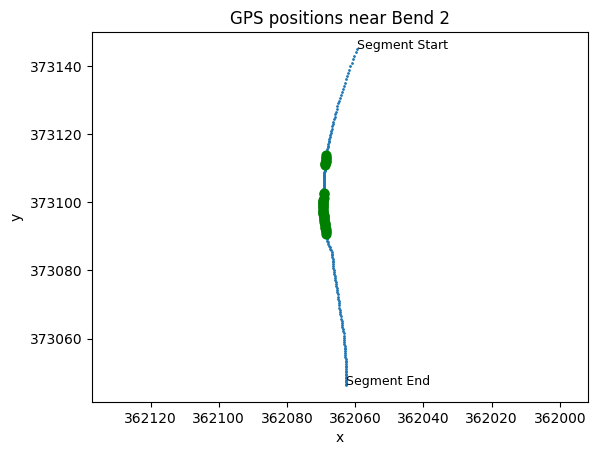

Bend 3: 178 points near the center - Avg Speed: 12.325965789662922
[ 8.6259407  11.42079442 13.13597856 14.17194783 14.58763047]
First bend is a right bend
Start of focused points: 2214


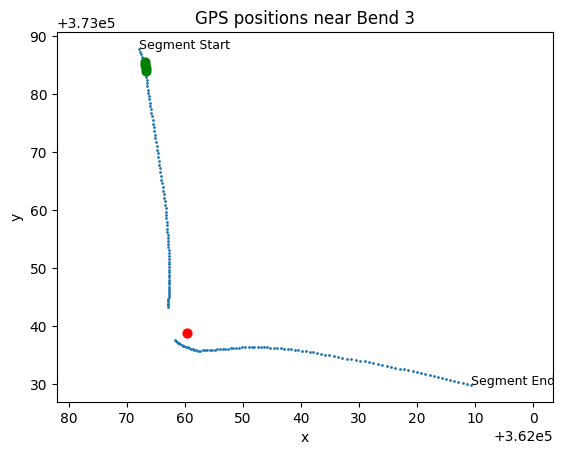

Bend 4: 180 points near the center - Avg Speed: 11.289669650999999
[1.17868465 1.59933927 2.02701199 2.3136979  2.42904872]
First bend is a right bend
Start of focused points: 2960


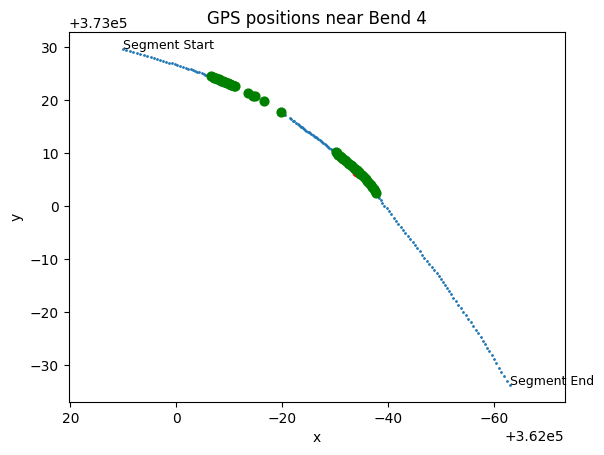

Bend 5: 136 points near the center - Avg Speed: 16.752818314705877
[1.65163717 1.27130922 1.43099546 2.07501452 2.94832346]
First bend is a right bend
Start of focused points: 3790


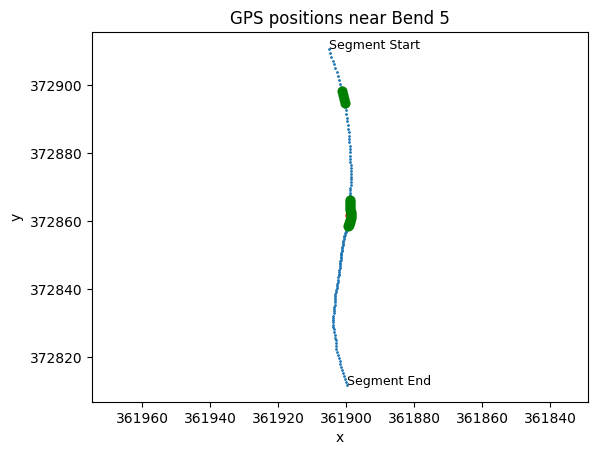

Bend 6: 135 points near the center - Avg Speed: 16.685815590814816
[3.0187594  4.31281367 4.97957459 4.57231014 3.91002052]
First bend is a right bend
Start of focused points: 3892


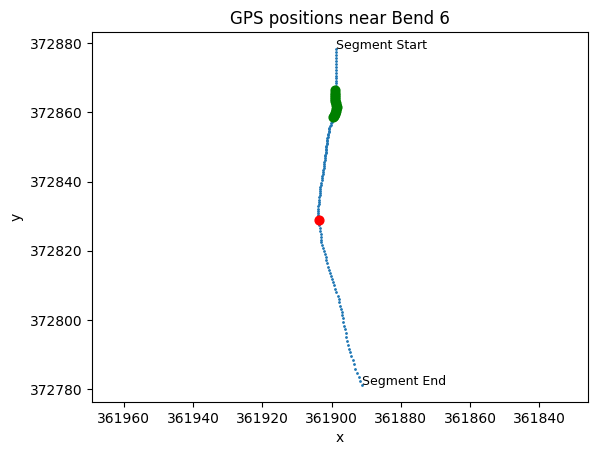

Bend 7: 106 points near the center - Avg Speed: 21.0464200045283
[0.72619428 0.9806351  0.78926139 0.5550555  0.50606062]
First bend is a left bend
Start of focused points: 4503


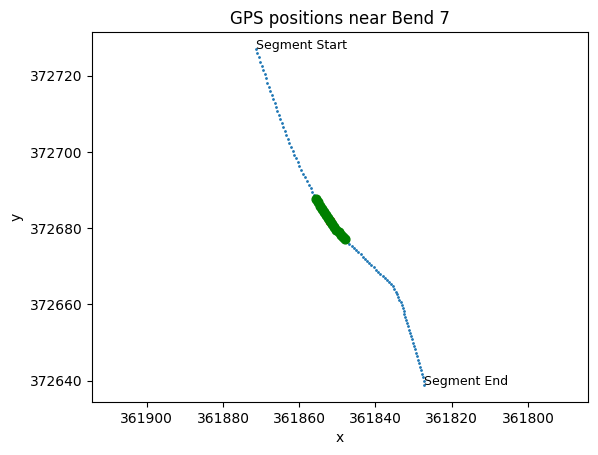

Bend 8: 107 points near the center - Avg Speed: 20.846336680186916
[-2.29439704 -2.56999843 -2.93246746 -3.24189424 -3.40535042]
First bend is a left bend
Start of focused points: 4503


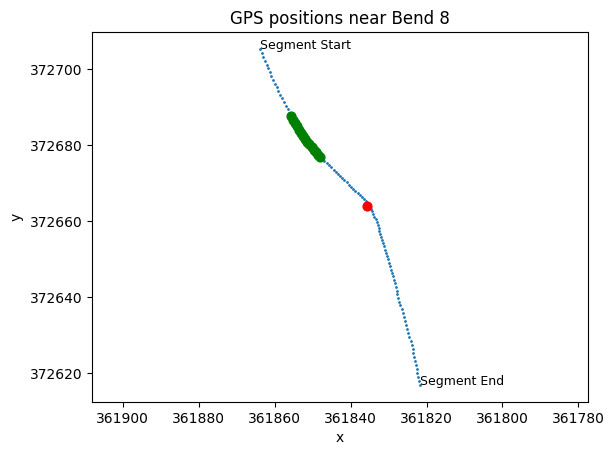

Bend 9: 143 points near the center - Avg Speed: 16.13869162083916
[-0.88854848 -0.78505509 -0.55800258 -0.17426613  0.21571857]
First bend is a left bend
Start of focused points: 4983


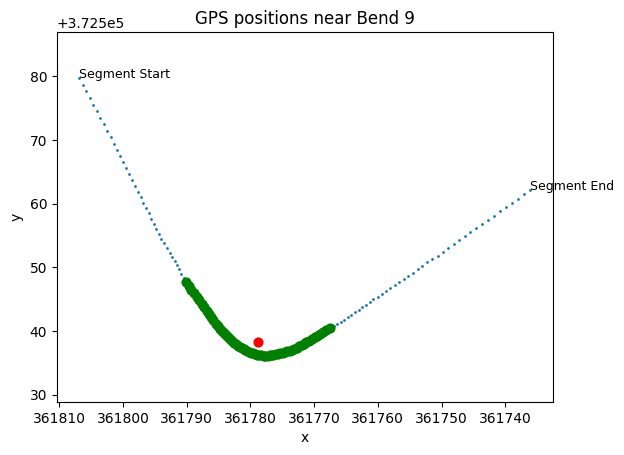

In [176]:
bends_for_curve_fitting = []

for i, bend in enumerate(cluster_centers):
    records = get_points_near_a_cluster_estimated_center(bend, positions, distance_threshold=50)
    print(f"Bend {i}: {len(records)} points near the center - Avg Speed: {np.mean([float(pos['speed']) for pos in records])}")

    focused_points, first_bend_sign = find_first_bend_from_series(records, min_degree_threshold=7)

    if focused_points is not None:
        start_of_focused_points = focused_points[0]
        start_of_focused_points_frame = time_stamp_to_frame_number(start_of_focused_points['time'])
        print(f"Start of focused points: {start_of_focused_points_frame}")

    plot_bend(f"Bend {i}", bend, records, focused_points)

    if len(records) > 0 and focused_points is not None:
        bends_for_curve_fitting.append({
            "bend": bend,
            "focused_points": focused_points,
            "Estimated_start_frame": start_of_focused_points_frame,
            "first_bend_sign": "Left" if first_bend_sign < 0 else "Right"
        })

# Kasa Iterative Curve Fitting

In [166]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import least_squares

# class Circle:
#     def __init__(self, a, b, r, s, j):
#         self.a = a  # X-coordinate of the center
#         self.b = b  # Y-coordinate of the center
#         self.r = r  # Radius
#         self.s = s  # Root mean square error
#         self.j = j  # Total number of iterations

# class Data:
#     def __init__(self, X, Y):
#         self.X = np.array(X)
#         self.Y = np.array(Y)
#         self.n = len(X)

# def geometric_distance(params, X, Y):
#     a, b, r = params
#     return np.sqrt((X - a)**2 + (Y - b)**2) - r

# def Sigma(data, circle):
#     # Compute the root mean square error (estimate of sigma)
#     distances = np.sqrt((data.X - circle.a)**2 + (data.Y - circle.b)**2)
#     sigma = np.sqrt(np.mean((distances - circle.r)**2))
#     return sigma

# def CircleFitIterative(data, initial_guess=None, max_iterations=100, tol=1e-9):
#     if initial_guess is None:
#         # Use the Kasa method to obtain an initial guess
#         initial_guess = CircleFitByKasa(data)
#         initial_params = [initial_guess.a, initial_guess.b, initial_guess.r]
#     else:
#         initial_params = initial_guess

#     # Perform the iterative fitting using Levenberg–Marquardt algorithm
#     result = least_squares(geometric_distance, initial_params, args=(data.X, data.Y), max_nfev=max_iterations, ftol=tol, xtol=tol, gtol=tol)

#     # Extract the optimized parameters
#     a, b, r = result.x
#     s = Sigma(data, Circle(a, b, r, 0, 0))
#     j = result.nfev  # Number of function evaluations

#     return Circle(a, b, r, s, j)

# def CircleFitByKasa(data):
#     # Center the data points
#     Xi = data.X - np.mean(data.X)
#     Yi = data.Y - np.mean(data.Y)
#     Zi = Xi**2 + Yi**2

#     # Compute moments
#     Mxx = np.mean(Xi**2)
#     Myy = np.mean(Yi**2)
#     Mxy = np.mean(Xi * Yi)
#     Mxz = np.mean(Xi * Zi)
#     Myz = np.mean(Yi * Zi)

#     # Solve the system of equations using Cholesky factorization
#     G11 = np.sqrt(Mxx)
#     G12 = Mxy / G11
#     G22 = np.sqrt(Myy - G12**2)

#     D1 = Mxz / G11
#     D2 = (Myz - D1 * G12) / G22

#     # Compute parameters of the fitting circle
#     C = D2 / G22 / 2
#     B = (D1 - G12 * C) / G11 / 2

#     # Assemble the output
#     a = B + np.mean(data.X)
#     b = C + np.mean(data.Y)
#     r = np.sqrt(B**2 + C**2 + Mxx + Myy)
#     s = Sigma(data, Circle(a, b, r, 0, 0))
#     j = 0  # Number of iterations (not applicable for Kasa's method)

#     return Circle(a, b, r, s, j)

# f_bend = bends_for_curve_fitting[1]['points']
# order_by_time = sorted(f_bend, key=lambda x: time_stamp_to_seconds(x['time']))
# X = [float(pos['x']) for pos in order_by_time]
# Y = [float(pos['y']) for pos in order_by_time]

# diff_x = np.diff(X)
# diff_y = np.diff(Y)
# angles = np.arctan2(diff_x, diff_y)
# angles = np.arctan2(np.sin(angles), np.cos(angles)) # normalize angles
# angles = np.degrees(angles)

# angles = np.diff(angles)

# # smooth angles with gaussian filter
# angles = np.convolve(angles, np.ones(3) / 3, mode='same')


# # apply median filter
# angles = apply_median_filter(angles, 10)

# # plot angles
# plt.plot(angles)
# plt.show()

# min_degree = 0.5

# print(f"Found {len(X)} points before filtering")
# print(angles[:10])

# angle_threshold_mask = [np.abs(angles) > min_degree]
# print(angle_threshold_mask[:10])

# X_a = np.array(X[1:-1])[np.abs(angles) > min_degree]
# Y_a = np.array(Y[1:-1])[np.abs(angles) > min_degree]

# # # ignore after sign change
# # angles_temp = angles[np.abs(angles) > min_degree]
# # angle_sign = np.sign(angles_temp)
# # initial_angle = angle_sign[1]

# # X_a = []
# # Y_a = []

# # for i in range(1, min(len(X)-1, len(angles))):
# #     if np.abs(angles[i-1]) > min_degree:
# #         if not (angle_sign[i-1] != initial_angle):
# #             break
# #         X_a.append(X[i])
# #         Y_a.append(Y[i])


# print(f"Found {len(X_a)} points after filtering")

# data = Data(X_a,Y_a)
# fitted_circle = CircleFitIterative(data)


# print(f"Center: ({fitted_circle.a}, {fitted_circle.b})")
# print(f"Radius: {fitted_circle.r}")
# print(f"RMS Error: {fitted_circle.s}")
# print(f"Iterations: {fitted_circle.j}")

# plt.scatter(X, Y)
# plt.scatter(fitted_circle.a, fitted_circle.b, color='red')
# plt.scatter(X_a, Y_a, color='green')
# plt.text(
#     X[0],
#     Y[0],
#     'Segment Start',
#     fontsize=9,
#     color='black'
# )

# plt.text(
#     X[-1],
#     Y[-1],
#     'Segment End',
#     fontsize=9,
#     color='black'
# )

# circle = plt.Circle((fitted_circle.a, fitted_circle.b), fitted_circle.r, color='r', fill=False)

# plt.gca().add_artist(circle)
# plt.axis('equal')
# plt.show()


# Visualise

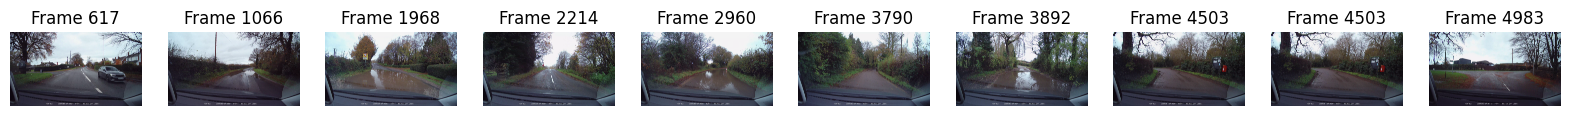

In [167]:
if bends_for_curve_fitting:
	frames = print_frames([bend['Estimated_start_frame'] for bend in bends_for_curve_fitting])
	for i, frame in enumerate(frames):
		output_file = os.path.join(output_folder, f"bend_{i}_frame_{bends_for_curve_fitting[i]['Estimated_start_frame']}_{bends_for_curve_fitting[i]['first_bend_sign']}.jpg")
		cv2.imwrite(output_file, frame)
else:
	print("No bends found for curve fitting.")
	


# Output Bend CSV

In [168]:
columns = ["frame", "bend_direction"]
data = []

for bend in bends_for_curve_fitting:
    data.append([bend['Estimated_start_frame'], bend['first_bend_sign']])

import pandas as pd
df = pd.DataFrame(data, columns=columns)
df

,frame,bend_direction
0,617,Left
1,1066,Right
2,1968,Left
3,2214,Right
4,2960,Right
5,3790,Right
6,3892,Right
7,4503,Left
8,4503,Left
9,4983,Left


In [169]:
csv_save_path = os.path.join(output_folder, "bend_directions.csv")
df.to_csv(csv_save_path, index=False)
print(f"Saved bend directions to {csv_save_path}")

Saved bend directions to /home/aap9002/Stereo-Road-Curvature-Dashcam/day/042/bends/bend_directions.csv
